<link rel="stylesheet" href="slides.css">

# Fagskolen lørdag 13.desember 2026

# Intro til Maskinlæring i Akvakultur (RAS)

Denne notebooken demonstrerer hvordan vi kan bruke data fra et RAS-anlegg til å forstå sammenhenger og lage enkle prediksjoner.

**Mål:**
1. Laste inn data (som fra Excel).
2. Se på dataene (Visualisering).
3. Lage en enkel modell for å forutsi biomasse (Maskinlæring).

## Oversikt over prosessen
![Data Science Lifecycle](https://learn.microsoft.com/en-us/azure/architecture/data-science-process/media/overview/tdsp-lifecycle2.png)

Hvis vi ikke stiller det rette spørsmålet, og har de rette dataene, så kommer vi ikke i mål uansett hvor gode modeller vi bygger.

In [1]:
# Vi importerer nødvendige verktøy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Setter en pen stil på plottene
sns.set_theme(style="whitegrid")

## Steg 1: Laste inn data
Vi later som vi henter data fra loggen til anlegget. Her ligger det i en CSV-fil (som er lett å eksportere fra Excel).

In [2]:
filename = "data/ras_data.csv"
# Laste inn data
df = pd.read_csv(filename)

# Vise de første 5 radene
df.head()

,Dato,Temperatur_C,Oksygen_mgL,Foring_kg,Biomasse_kg
0,2024-01-01,12.5,9.2,150,5000
1,2024-01-02,12.6,9.1,155,5050
2,2024-01-03,12.4,9.3,152,5100
3,2024-01-04,12.5,9.0,158,5160
4,2024-01-05,12.7,8.9,160,5220


In [3]:
df.columns

Index(['Dato', 'Temperatur_C', 'Oksygen_mgL', 'Foring_kg', 'Biomasse_kg'], dtype='object')

In [4]:
round(df.describe(), 1)

,Temperatur_C,Oksygen_mgL,Foring_kg,Biomasse_kg
count,30.0,30.0,30.0,30.0
mean,12.8,8.9,166.8,5933.7
std,0.3,0.4,9.2,611.7
min,12.3,8.0,150.0,5000.0
25%,12.5,8.6,160.0,5425.0
50%,12.7,9.0,165.0,5915.0
75%,13.0,9.1,175.0,6410.0
max,13.5,9.4,185.0,6990.0


In [5]:
target = 'Biomasse_kg'
features = df.columns.drop(['Dato', target])

## Steg 2: Utforske dataene (EDA)
Før vi gjør noe "smart", må vi se på hva vi har. Er det noen sammenhenger?

In [35]:
round(df.corr(numeric_only = True), 2)

,Temperatur_C,Oksygen_mgL,Foring_kg,Biomasse_kg
Temperatur_C,1.00,-0.98,0.92,0.56
Oksygen_mgL,-0.98,1.00,-0.89,-0.49
Foring_kg,0.92,-0.89,1.00,0.75
Biomasse_kg,0.56,-0.49,0.75,1.00


### Temperatur og oksygen over tid

In [33]:
def plot_time_series(df, date_col, value_col, label=None, title=None, figsize=(18, 6), color=None):
    """
    Plott en tidsserie fra dataframe uten å endre originaldata.
    date_col: kolonnenavn med datoer (string)
    value_col: kolonnenavn med verdier som skal plottes (string)
    label: etikett i legend (string)
    title: plot-tittel (string)
    """
    x = pd.to_datetime(df[date_col])
    y = df[value_col]

    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, marker='o', label=label or value_col, color=color)
    plt.xticks(rotation=45)
    plt.title(title or f"{label or value_col} over time")
    plt.show()

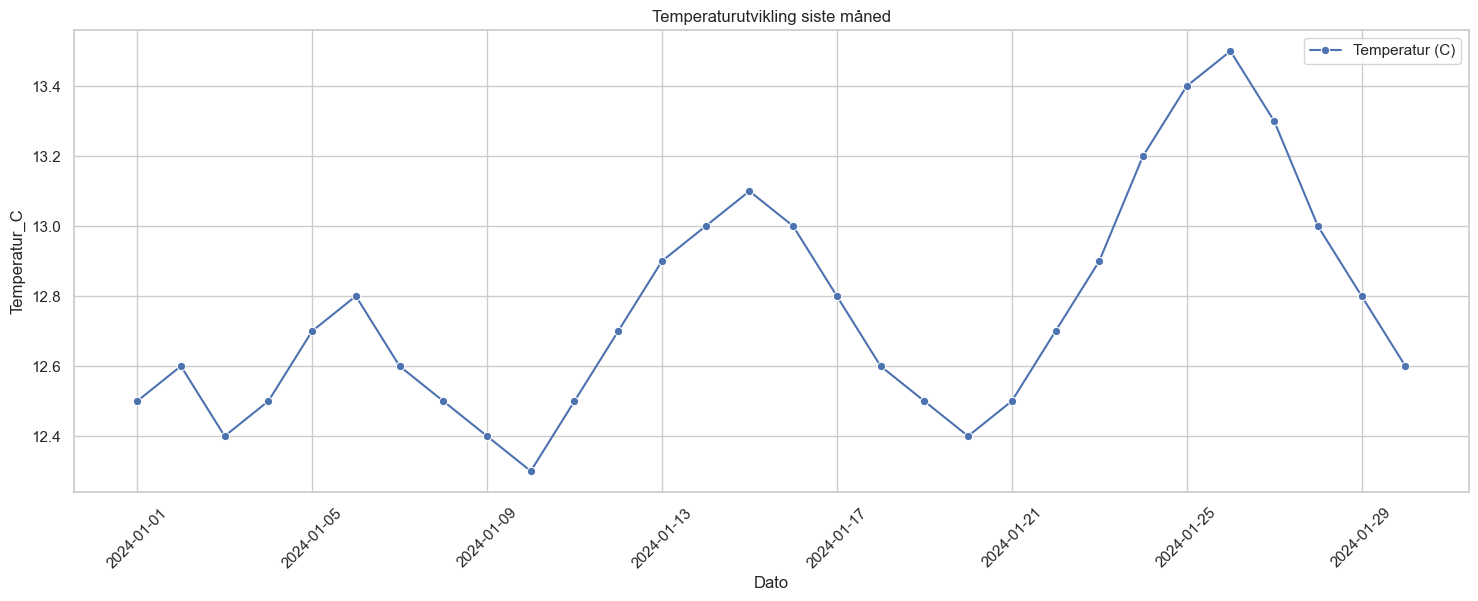

In [34]:
# Bruk funksjonen for temperatur
plot_time_series(df, 'Dato', 'Temperatur_C', label='Temperatur (C)', title="Temperaturutvikling siste måned")

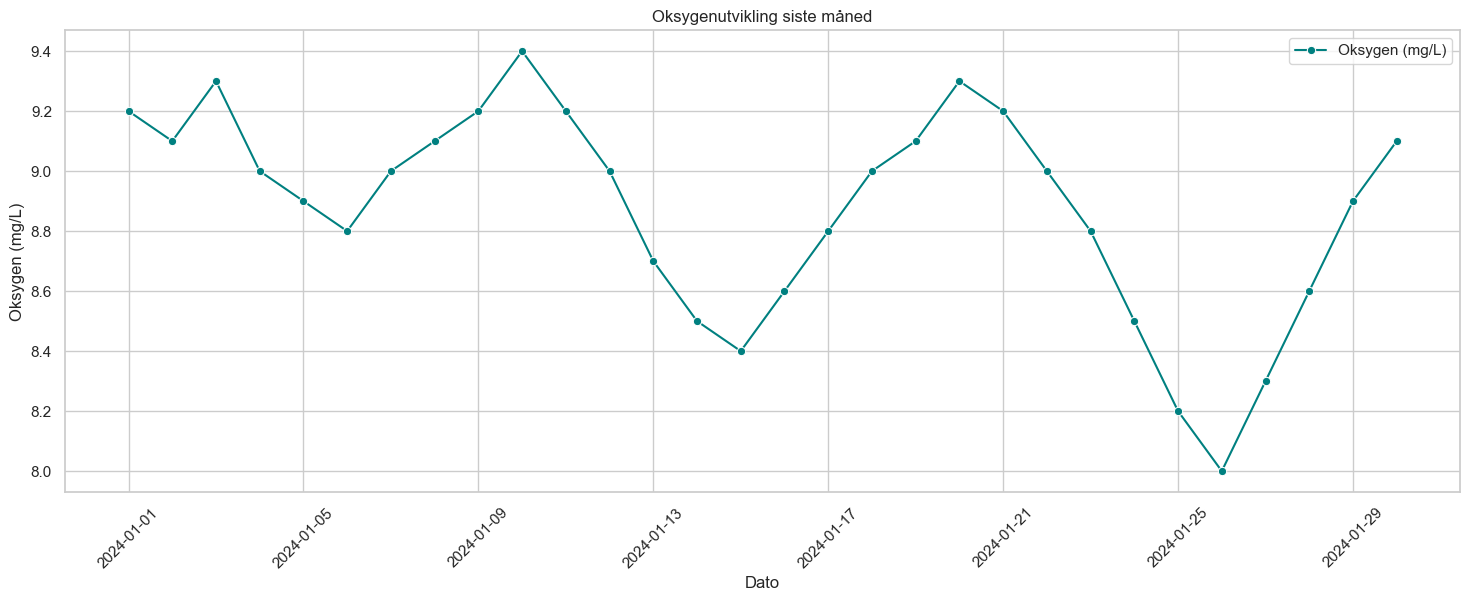

In [9]:

# Bruk funksjonen for oksygen
plot_time_series(df, 'Dato', 'Oksygen_mgL', label='Oksygen (mg/L)', title="Oksygenutvikling siste måned", color='teal')

Av grafene kan vi se:
- Repeterende (sykliske) mønstre i både temperatur og oksygen
- en økende trend i temperatur
- en nedadgående trend i oksygen.

### Sammenheng biomasse og de ulike "features" / parametre

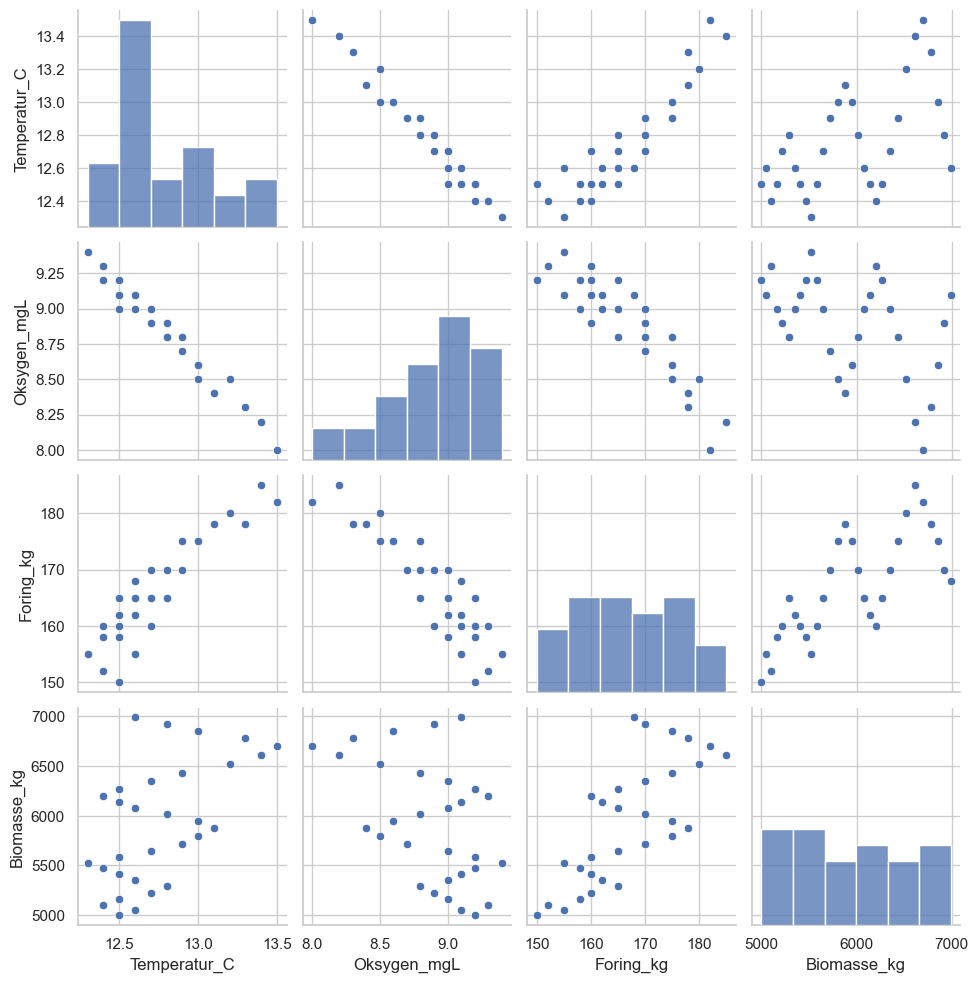

In [23]:
sns.pairplot(df)

## Steg 3: Maskinlæring (Enkel modell)
Kan vi lære datamaskinen å gjette biomasse basert på temperatur og fôring?

Vi bruker en **Lineær Regresjon**. Tenk på det som å tegne den "beste rette linjen" gjennom punktene.

In [14]:
def train_model(df, features, target, test_size=0.2, random_state=42):
    """
    Trener en LineærRegresjon på df[features] for å predikere df[target].
    Returnerer: X_test, y_test, modell
    """
    X = df[features]
    y = df[target]

    # Del data i trening og test <= Hvorfor?
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Tren modellen <= mange ulike å velge mellom!
    modell = LinearRegression()
    modell.fit(X_train, y_train)

    print("Modellen er ferdig trent!")
    return X_test, y_test, modell


In [15]:
# 1. Velg hva vi vil bruke til å gjette (Features) og hva vi vil gjette (Target)
features = ['Temperatur_C', 'Foring_kg']
target = 'Biomasse_kg'

X_test, y_test, modell = train_model(df, features, target)

Modellen er ferdig trent!


## Steg 4: Hvor bra traff vi?
La oss se hva modellen gjetter på test-dataene våre, og sammenligne med fasiten.

In [16]:
def plot_actual_vs_predicted(y_true, prediksjoner, y_true_label="Faktisk", pred_label="Predikert"):
    # Plotte faktisk vs prediksjon
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=prediksjoner, s=100)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Fasit-linje
    plt.legend(['Modell vs faktisk', 'Perfekt (y=x)'], loc='best')
    plt.xlabel(y_true_label)
    plt.ylabel(pred_label)
    plt.title("Hvor godt treffer modellen? (På linjen = Perfekt)")
    plt.show()


def predict_and_show(modell, X_test, y_test, round_decimals=1):
    """
    Lager prediksjoner med `modell` på `X_test` og returnerer en DataFrame med:
      - Faktisk <y_test.name>
      - Modellens prediksjon (<y_test.name>)
      - Feil (<y_test.name>) = Faktisk - Predikert

    Deriverer navnet på kolonnen fra y_test.name. Returnerer resultat-DataFrame med samme indeks som y_test.
    """
    col_base = y_test.name or "target"
    y_pred = modell.predict(X_test)
    preds = pd.Series(y_pred, index=y_test.index).round(round_decimals)

    col_true = f"Faktisk ({col_base})"
    col_pred = f"Predikert ({col_base})"
    col_err = f"Feil ({col_base})"

    resultat = pd.DataFrame({col_true: y_test, col_pred: preds})
    resultat[col_err] = (resultat[col_true] - resultat[col_pred]).round(round_decimals)

    plot_actual_vs_predicted(y_test, preds, y_true_label=col_true, pred_label=col_pred)
    return resultat

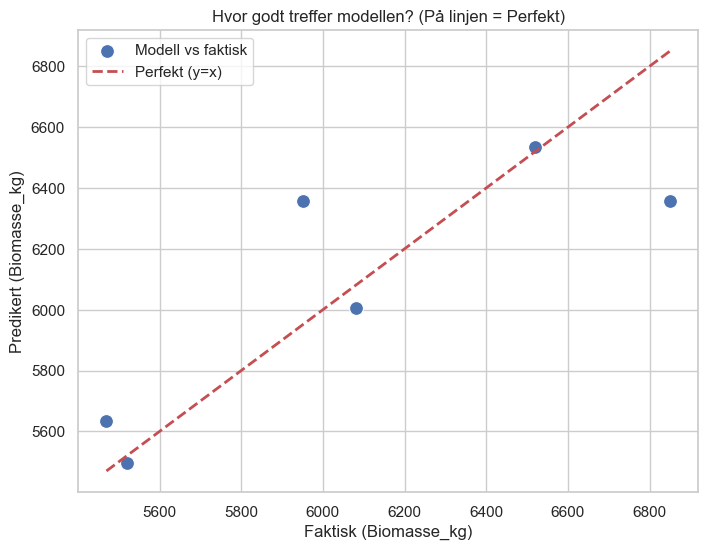

In [17]:
eval = predict_and_show(modell, X_test, y_test)

In [18]:
eval.head()

,Faktisk (Biomasse_kg),Predikert (Biomasse_kg),Feil (Biomasse_kg)
27,6850,6357.8,492.2
15,5950,6357.8,-407.8
23,6520,6534.2,-14.2
17,6080,6005.0,75.0
8,5470,5633.6,-163.6


In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def evaluate_model(y_true, y_pred):
    # Beregn noen vanlige evalueringsmetrikker for modellens prediksjoner
    mae = mean_absolute_error(y_true, y_pred)
    #rmse = root_mean_squared_error(y_true, y_pred)
    rmse = ((y_true.values - y_pred) ** 2).mean() ** 0.5
    r2 = r2_score(y_true, y_pred)
    mape = (abs((y_true.values - y_pred) / y_true.values).mean()) * 100

    print(f"MAE:  {mae:.2f} kg")
    print(f"RMSE: {rmse:.2f} kg")
    print(f"MAPE: {mape:.2f} %")
    print(f"R^2:  {r2:.3f}")

In [20]:

y_true = eval[f'Faktisk ({target})']
y_pred = eval[f'Predikert ({target})']
evaluate_model(y_true, y_pred)

MAE:  196.03 kg
RMSE: 271.32 kg
MAPE: 3.15 %
R^2:  0.703


## 5. Forbedring av modell
Kan vi lage en bedre modell? Hva med å se på endring i Biomasse istedenfor total.

In [21]:
# Tar vare på original dataframe
old_df = df.copy()

In [22]:
# Lag ny kolonne med daglig endring i biomasse (kg)
df['endring'] = df['Biomasse_kg'].diff() #.fillna(0)

# Fjerner første rad siden endring er 0 der
df = df.dropna()

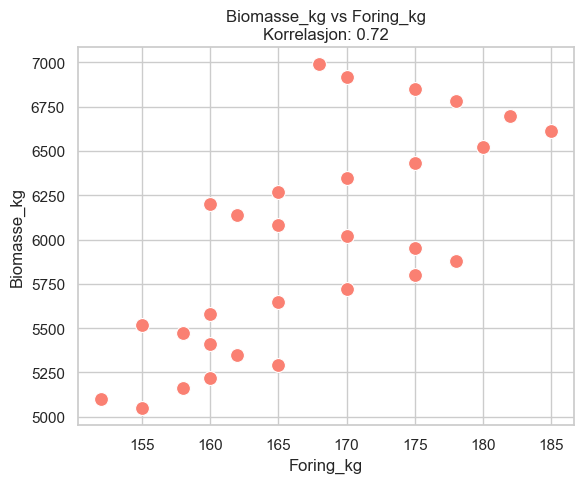

In [23]:
fig, axes = scatterplot_feature_vs_target(df, ['Foring_kg'], target)


Modellen er ferdig trent!


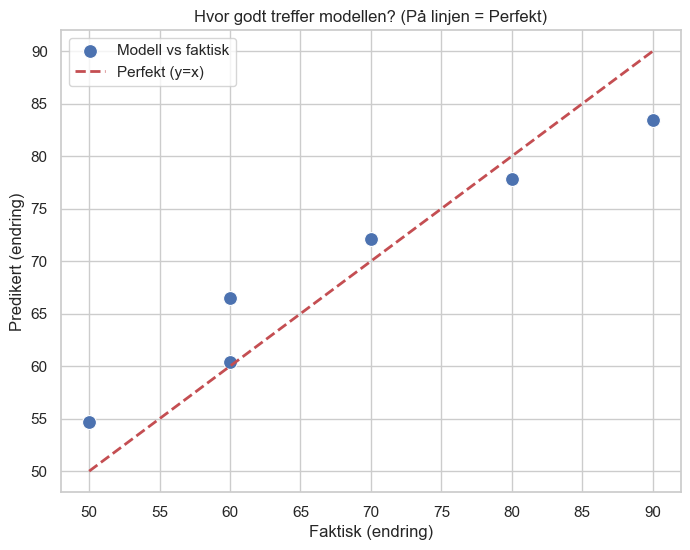

MAE:  3.75 kg
RMSE: 4.42 kg
MAPE: 5.66 %
R^2:  0.892


In [24]:
target = 'endring'
X_test, y_test, modell = train_model(df, features, target=target)
eval = predict_and_show(modell, X_test, y_test)
y_true = eval[f'Faktisk ({target})']
y_pred = eval[f'Predikert ({target})']
evaluate_model(y_true, y_pred)

# Referanser
Kaggle er en platform for ML konkurranser, og har flere [fine kurs](https://www.kaggle.com/learn):
- [Kaggle: Python](https://www.kaggle.com/learn/python)
- [Kaggle: Intro to machine learning](https://www.kaggle.com/learn/intro-to-machine-learning)
- [Kaggle: Time Series](https://www.kaggle.com/learn/time-series)

Google har kræsjkurs i ML:
- [Google: ML Crash Course](https://developers.google.com/machine-learning/crash-course/), spesielt [Gradient Descent demo](https://developers.google.com/machine-learning/crash-course/linear-regression/gradient-descent-exercise)
